Plots and Figures to understand poisson distribution

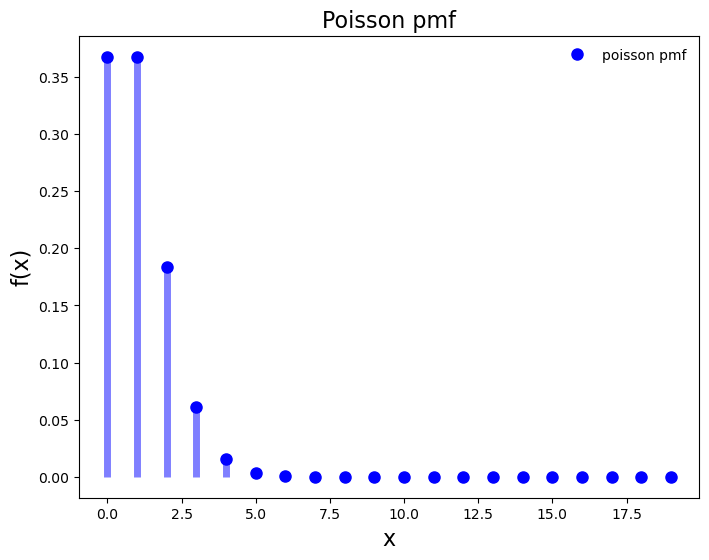

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# set up the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# plot the poisson pmf
mu = 1
x = np.arange(0, 20)
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('f(x)', fontsize=16)
ax.set_title('Poisson pmf', fontsize=16)
ax.legend(loc='best', frameon=False)

plt.show()

In [101]:
# Just to see what it looks like

print("Poisson distribution with mu = ", mu, ":")
for i in range(0, 20):
    print(i, poisson.pmf(i, mu))
    
# Also we print random values of the poisson distribution

print("\nRandom values of the Poisson distribution with mu = ", mu, ":")
print(poisson.rvs(mu, size=10))

Poisson distribution with mu =  1 :
0 0.36787944117144233
1 0.36787944117144233
2 0.18393972058572114
3 0.06131324019524039
4 0.015328310048810101
5 0.00306566200976202
6 0.0005109436682936698
7 7.299195261338139e-05
8 9.123994076672672e-06
9 1.013777119630298e-06
10 1.0137771196302987e-07
11 9.216155633002698e-09
12 7.680129694168931e-10
13 5.907792072437641e-11
14 4.219851480312585e-12
15 2.813234320208389e-13
16 1.7582714501302425e-14
17 1.0342773236060258e-15
18 5.745985131144604e-17
19 3.0242027006024186e-18

Random values of the Poisson distribution with mu =  1 :
[0 0 0 1 0 2 1 0 2 3]


In [138]:
# example matrix to understand the dimensions

print("\nRandom values of a 3D matrix with dimensions [2,3,4]:")
print(np.random.rand(2,3,4))



Random values of a 3D matrix with dimensions [2,3,4]:
[[[0.26391069 0.98225776 0.11310966 0.97879748]
  [0.9138478  0.46545585 0.89176233 0.92373851]
  [0.22749524 0.28843605 0.38303772 0.38930962]]

 [[0.2427535  0.50265362 0.35431159 0.23494291]
  [0.74383118 0.76815574 0.87076205 0.27047452]
  [0.46323814 0.21594002 0.91261701 0.46834218]]]


Actual MDP

In [3]:
import numpy as np
from scipy.stats import norm, poisson
from itertools import product

DEBUG = 1

    
class MDP:
    def __init__(self, n_users, n_rb, buffer_size, cqi_values, lambdas=[3,1], alpha=1, beta=1, x=1, y=1):
        # MDP parameters
        self.N = n_users
        self.M = n_rb
        self.B = buffer_size
        self.cqi = cqi_values
        self.lambdas = lambdas

        # Cost function parameters
        self.alpha = alpha
        self.beta = beta
        self.x = x
        self.y = y

        self.generate_actions()

        self.state_space = list(product(range(self.B + 1), repeat=self.N))
        self.state_space_size = len(self.state_space)
        self.action_space_size = len(self.actions)

        self.generate_transition_matrix()

    def generate_actions(self):
        # Generate all possible resource allocation combinations
        all_combinations = list(product(range(self.M + 1), repeat=self.N))
        # Filter valid combinations with total allocation <= M
        valid_combinations = [comb for comb in all_combinations if sum(comb) <= self.M]
        
        self.actions = np.array(valid_combinations)
        
    def generate_transition_matrix(self):
        self.transition_matrix = np.zeros((self.action_space_size,
                                            self.state_space_size,
                                            self.state_space_size))
        for a_idx, a in enumerate(self.actions):
            for b_idx, b in enumerate(self.state_space):
                for b_prime_idx, b_prime in enumerate(self.state_space):
                    self.transition_matrix[a_idx, b_idx, b_prime_idx] += self.transition_probability(b_prime, b, a, self.lambdas)

                    # normalize the transition matrix
                    self.transition_matrix[a_idx, b, :] /= np.sum(self.transition_matrix[a_idx, b, :])

    def transition_probability(self, b_prime, b, a, lambdas):
        prob_total = 1.0
        
        for i in range(self.N):
            l_i = b_prime[i] - max(0, b[i] - a[i]*self.cqi[i])
            
            # If b' >= B, accumulate the probability of buffer sizes greater than or equal to B
            if b_prime[i] >= self.B:
                prob_l_i = poisson.cdf(2*self.B, lambdas[i]) - poisson.cdf(self.B - 1, lambdas[i])
        
            else:
                # Calculate the probability that l_i equals the calculated value
                prob_l_i = poisson.pmf(l_i, lambdas[i])
            
            # Multiply this probability to the total probability
            prob_total *= prob_l_i
        
        return prob_total
    
    def cost(self, b, a):
        cost_total = 0.0
        
        for i in range(self.N):
            l_i = np.random.poisson(self.lambdas[i])
            rest_i = max(0, b[i] - self.cqi[i]*a[i])
            
            cost_i = self.alpha * max(0, l_i + rest_i - self.B)**self.x + self.beta * rest_i**self.y
            cost_total += cost_i
        
        return cost_total
    
    def cost_v2(self, b, a, num_simulations):
        total_cost = 0.0
        
        for _ in range(num_simulations):
            cost_total = 0.0
            
            for i in range(self.N):
                l_i = np.random.poisson(self.lambdas[i])
                rest_i = max(0, b[i] - self.cqi[i] * a[i])
                
                cost_i = self.alpha * max(0, l_i + rest_i - self.B) ** self.x + self.beta * rest_i ** self.y
                cost_total += cost_i
            
            total_cost += cost_total
        
        expected_cost = total_cost / num_simulations
        return expected_cost
    
    
    

In [5]:
N, M, B , CQI, L = 2, 2, 2, [1,1], [1,1]
mdp = MDP(N,M,B,CQI, L)

print("Matriz de transición: \n ",  mdp.transition_matrix)

#print("Espacio de estados: \n", mdp.state_space)

Matriz de transición: 
  [[[0.14361408 0.0388721  0.03498716 0.05886363 0.07479628 0.06732102
   0.08022814 0.09560988 0.08070798]
  [0.         0.11358657 0.09134585 0.         0.14132116 0.11364989
   0.         0.12454465 0.09667603]
  [0.         0.         0.16969226 0.         0.         0.18595938
   0.         0.         0.14434836]
  [0.         0.         0.         0.13533528 0.13533528 0.09586249
   0.09586249 0.09586249 0.0679026 ]
  [0.         0.         0.         0.         0.13533528 0.09586249
   0.         0.09586249 0.0679026 ]
  [0.         0.         0.         0.         0.         0.09586249
   0.         0.         0.0679026 ]
  [0.         0.         0.         0.         0.         0.
   0.09586249 0.09586249 0.0679026 ]
  [0.         0.         0.         0.         0.         0.
   0.         0.09586249 0.0679026 ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.0679026 ]]

 [[0.10482309 0.02837253 0.02553693 0.04296

In [27]:
print(mdp.state_space)
print(mdp.state_space_size)

#print shape of the transition matrix

print(mdp.transition_matrix.shape)

# save the matrix on a txt file

np.savetxt("transition_matrix_a0.txt", mdp.transition_matrix[0,:,:])

np.savetxt("transition_matrix_a1.txt", mdp.transition_matrix[1,:,:])

#print(mdp.transition_matrix[0,1,6])

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
9
(6, 9, 9)


In [5]:
print(mdp.transition_matrix[0,:,:])

[[0.14361408 0.0388721  0.03498716 0.05886363 0.07479628 0.06732102
  0.08022814 0.09560988 0.08070798]
 [0.         0.11358657 0.09134585 0.         0.14132116 0.11364989
  0.         0.12454465 0.09667603]
 [0.         0.         0.16969226 0.         0.         0.18595938
  0.         0.         0.14434836]
 [0.         0.         0.         0.13533528 0.13533528 0.09586249
  0.09586249 0.09586249 0.0679026 ]
 [0.         0.         0.         0.         0.13533528 0.09586249
  0.         0.09586249 0.0679026 ]
 [0.         0.         0.         0.         0.         0.09586249
  0.         0.         0.0679026 ]
 [0.         0.         0.         0.         0.         0.
  0.09586249 0.09586249 0.0679026 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.09586249 0.0679026 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.0679026 ]]


Value Iteration v2

In [ ]:
# Value iteration algorithm for the MDP using the cost function

def value_iteration(mdp, gamma=0.9, epsilon=0.01):
    V = np.zeros(mdp.state_space_size)
    policy = np.zeros((mdp.state_space_size, mdp.action_space_size))
    delta = float('inf')
    
    while delta > epsilon:
        delta = 0
        for s_idx, s in enumerate(mdp.state_space):
            v = V[s_idx]
            V[s_idx] = max([mdp.cost(s, a) + gamma * np.dot(mdp.transition_matrix[a_idx, s_idx, :], V) for a_idx, a in enumerate(mdp.actions)])
            delta = max(delta, abs(v - V[s_idx]))
    
    for s_idx, s in enumerate(mdp.state_space):
        policy[s_idx, :] = [mdp.cost(s, a) + gamma * np.dot(mdp.transition_matrix[a_idx, s_idx, :], V) for a_idx, a in enumerate(mdp.actions)]
    
    return V, policy

Value Iteration v1

In [747]:
# Value iteration algorithm for the MDP

# Loop:
#     \Delta <- 0
#     Loop for each s \in S:
#         v <- V(s)
#         V(s) <- max_a \sum_{s', r} p(s', r | s, a) [r + \gamma V(s')]
#         \Delta <- max(\delta, |v - V(s)|)
# until \Delta < \theta

# output a deterministic policy, \pi \sim \pi_*, such that
# \pi(s) = argmax_a \sum_{s', r} p(s', r | s, a) [r + \gamma V(s')]

DEBUGV = 0
def value_iteration(mdp, gamma=0.8, epsilon=0.001):
    # Initialize the value function
    V = np.zeros(mdp.state_space_size)
    V_prev = np.zeros(mdp.state_space_size)
    # Initialize the policy
    policy = np.zeros(mdp.state_space_size)

    # Initialize the value function with random values
    #V = np.random.rand(mdp.state_space_size)
    # Initialize the value function with all -10
    #V = np.full(mdp.state_space_size, -10)

    
    # Initialize the list of Vs for each iteration
    Vs = []
    Vo = []
    # Initialize the iteration counter
    iteration = 0
    
    rewards = []
    difs = [] 

    ###################################
    # Value Iteration
    ###################################

    while True:
        # Initialize delta
        delta = 1e-2

        # max value will be a vector of size N, where N is the number of users an each entry is -np.inf
        max_value = np.full(mdp.state_space_size, -np.inf)
        max_action = np.full(mdp.state_space_size, None)
        
        V_prev = V.copy()

        # For each state
        for s_idx, s in enumerate(mdp.state_space):
            # Initialize the max value and the max action
            
            value = np.zeros((mdp.state_space_size, mdp.action_space_size))

            for a_idx, a in enumerate(mdp.actions):
                # Initialize the value
                total_reward = 0
                # For each possible next state
                for s_prime_idx, s_prime in enumerate(mdp.state_space):
                    # Accumulate the expected value
                    value[s_idx, a_idx] += mdp.transition_matrix[a_idx, s_idx, s_prime_idx] * (mdp.cost(s, s_prime, a) + gamma * V[s_prime_idx])
                    #print("State ", s, " Action ", a, " Next state ", s_prime, " Reward ", mdp.reward(s, s_prime, a), " Value ", value[s_idx, a_idx])

                #if value[s_idx, a_idx] > max_value[s_idx]:
                    #max_value[s_idx] = value[s_idx, a_idx]
                    #max_action[s_idx] = a_idx

            max_value[s_idx] = np.max(value[s_idx, :])
            #max_action[s_idx] = np.argmax(value[s_idx, :])

            V[s_idx] = max_value[s_idx]

            #policy[s_idx] = max_action[s_idx]
            rewards.append(total_reward)
        
        dif_norm = np.linalg.norm(V_prev - V)
        print(dif_norm)
        
       
        difs.append(dif_norm)
                
        Vs.append(V.copy())
        Vo.append(V[0])

        # Increment the iteration counter
        iteration += 1
        
        # \pi(s) = argmax_a \sum_{s', r} p(s', r | s, a) [r + \gamma V(s')]


        if iteration == 50:


            ###################################
            # obtain the policy for each state
            ###################################

            for s_idx, s in enumerate(mdp.state_space):

                value = np.zeros((mdp.state_space_size, mdp.action_space_size))

                for a_idx, a in enumerate(mdp.actions):
                    # For each possible next state
                    for s_prime_idx, s_prime in enumerate(mdp.state_space):
                        # Accumulate the expected value
                        value[s_idx, a_idx] += mdp.transition_matrix[a_idx, s_idx, s_prime_idx] * (mdp.reward(s, s_prime, a) + gamma * V[s_prime_idx])

                max_action[s_idx] = np.argmax(value[s_idx, :])

                policy[s_idx] = max_action[s_idx]

            break

    
    return Vs, policy, rewards, difs, Vo

In [748]:
# test the algorithm

Vs, policy, rewards, difs, Vo = value_iteration(mdp)

print("Value function:")
print(Vs[-1])

# print (State[i], action taken) for each state
for i in range(mdp.state_space_size):
    print("Estado: ", mdp.state_space[i], " Politica " , policy[i], " Acción ", mdp.actions[int(policy[i])])




#print("Policy:")
#print(policy)


27.059028663369446
16.588494417343078
10.29885245648887
6.198159022796909
3.6066708034206156
2.0519485441159286
1.1517831537857406
0.641703424184633
0.3561279390898123
0.19725675565882786
0.10915614621686869
0.06037689615769904
0.03338898692942176
0.01846265892210998
0.010208603373843437
0.0056445564677798585
0.0031209687621839336
0.0017256283296361525
0.0009541228720702411
0.0005275467989328099
0.00029168729627953677
0.0001612775673543462
8.917238447448714e-05
4.930452515422487e-05
2.726108735566873e-05
1.507299535218536e-05
8.334047168169622e-06
4.607998654776832e-06
2.5478199371250494e-06
1.4087214300973423e-06
7.788996497169307e-07
4.306633211465752e-07
2.3811912608538338e-07
1.3165903471242408e-07
7.279593643489827e-08
4.024977916069489e-08
2.225460148337568e-08
1.2304839110453513e-08
6.803501511651713e-09
3.7617381844511594e-09
2.079918880699061e-09
1.1500097004932062e-09
6.35857399515328e-10
3.5156590465719207e-10
1.9439502807677171e-10
1.0748238453695421e-10
5.942366892826866e-

In [659]:
mdp.actions[int(policy[1])]

array([0, 0])

In [628]:
print(difs)

[13.548697218569016, 3.369796452843685, 0.7467450227858413, 0.15012549520113352, 0.02814573684239894, 0.0050117430228695066, 0.0008582082337686328, 0.000142572148251935, 2.311929886992941e-05, 3.674666594018211e-06]


In [574]:
print(mdp.actions)

print(mdp.state_space)

[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [2 0]]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


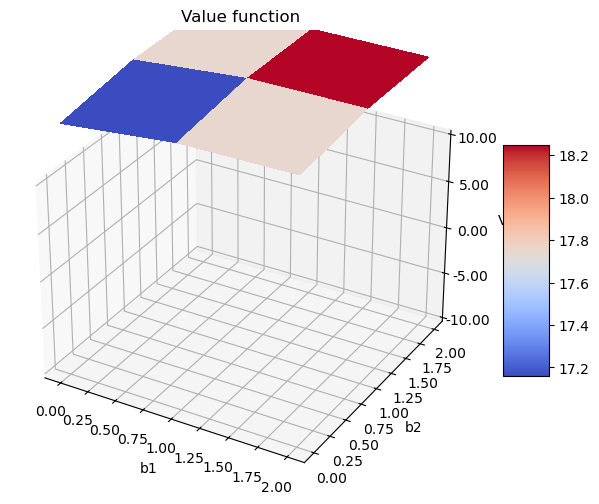

In [701]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')  

# Make data
X = np.arange(0, mdp.B + 1)
Y = np.arange(0, mdp.B + 1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((mdp.B + 1, mdp.B + 1))
for i in range(mdp.B + 1):
    for j in range(mdp.B + 1):
        Z[i, j] = Vs[-1][mdp.state_space.index((i, j))]

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis
ax.set_zlim(-10, 10)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('b1')
ax.set_ylabel('b2')
ax.set_zlabel('V')
ax.set_title('Value function')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



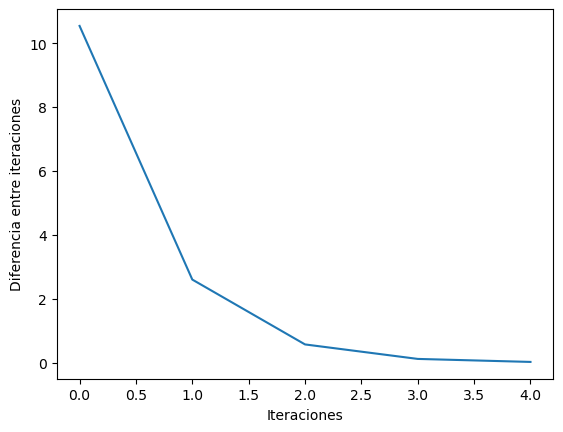

In [736]:
# plot difs

plt.plot(difs)
plt.ylabel('Diferencia entre iteraciones')
plt.xlabel('Iteraciones')
plt.show()



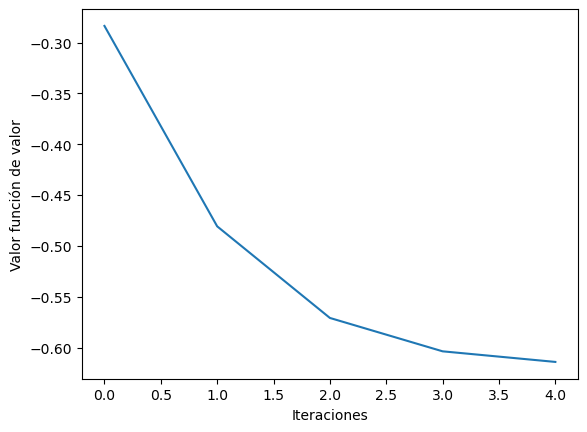

In [735]:
# plot Vo

plt.plot(Vo)
plt.ylabel('Valor función de valor')
plt.xlabel('Iteraciones')
plt.show()
